# Assignment 1
Linear and circular convolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.linalg import toeplitz, circulant, dft

plt.rcParams.update({
    "font.serif":["cm"],
    "font.size": 12})

colors = {
    "blue": "#377eb8",
    "orange": "#ff7f00",
    "green": "#4daf4a",
    "pink": "#f781bf",
    "brown": "#a65628",
    "purple": "#984ea3",
    "gray": "#999999",
    "red": "#e41a1c",
    "yellow": "#dede00",
    "black": "#000000",
}

## Part 1: Starter Exercise

Before using built-in functions, write the convolution function once!

**The Goal:** Implement 1D Linear Convolution (`mode='full'`) in three ways and verify they are identical.
1. **Manual Loops:** To appreciate the computational complexity.
2. **Matrix Algebra:** To leverage linear algebra tools.
3. **Built-in:** To make things more efficient.

In [2]:
def manual_convolution_loops(x, h, mode='full'):
    """
    Computes convolution y[n] = sum(x[k] * h[n-k]) using nested loops.
    Supports 'full', 'same', and 'valid' modes.
    TODO: Implement the convolution logic here
    """
    # TODO: Initialize output array
    # TODO: Loop over output samples
    # TODO: Handle different modes (full, same, valid)

    N = len(x)
    M = len(h)
    y = np.zeros(N+M-1, dtype=np.int64)

    for n in range(N+M-1):
        for k in range(M):
            if n-k < N and n-k >= 0:
                y[n] += h[k] * x[n-k]
                
    if mode == 'same':
        start_idx = (M - 1) // 2 
        return y[start_idx : start_idx + N]
    elif mode == 'valid':
        return y[M - 1: N]
    return y

    
def test_implementations():
    x = np.array([1, 2, 3, 4, 5])
    h = np.array([1, -1, 2, 3])
    
    print(f"Input x: {x}")
    print(f"Filter h: {h}")
    print(f"-"*30)

    for mode in ['full', 'same', 'valid']:
        # 1. Manual Implementation
        y_manual = manual_convolution_loops(x, h, mode=mode)
        
        # 2. Built-in Implementation (Numpy)
        y_builtin = np.convolve(x, h, mode=mode)
        
        print(f"Mode '{mode}':")
        print(f"  Manual:   {y_manual}")
        print(f"  Built-in: {y_builtin}")
        
        if np.allclose(y_manual, y_builtin):
            print(f"  Result:   MATCH")
        else:
            print(f"  Result:   MISMATCH")
    print(f"-"*30)

test_implementations()

Input x: [1 2 3 4 5]
Filter h: [ 1 -1  2  3]
------------------------------
Mode 'full':
  Manual:   [ 1  1  3  8 13 12 22 15]
  Built-in: [ 1  1  3  8 13 12 22 15]
  Result:   MATCH
Mode 'same':
  Manual:   [ 1  3  8 13 12]
  Built-in: [ 1  3  8 13 12]
  Result:   MATCH
Mode 'valid':
  Manual:   [ 8 13]
  Built-in: [ 8 13]
  Result:   MATCH
------------------------------


## Part 2: Linear Convolution as a Toeplitz Matrix

Now that we understand the loops, we show that convolution is simply a matrix-vector product $y = Ax$.

In [3]:
def demo_toeplitz_convolution():
    # Define a simple signal x and filter h
    x = np.array([1, 2, 3, 4])
    h = np.array([1, -1, 2]) # Length 3
    
    # Standard Numpy Convolve
    y_numpy = np.convolve(x, h, mode='full')
    print(f"Standard Convolution Output: {y_numpy}")
    
    # TODO: Construct Toeplitz matrix
    # H_mat = ...
    N = len(x)
    M = len(h)
    H_mat = np.zeros((N+M-1, N), dtype=np.int64)
    for c in range(N):
        H_mat[c:c+M, c] = h
    
    print("\nToeplitz Convolution Matrix (H):")
    print(H_mat)
    
    # TODO: Perform matrix multiplication
    y_matrix = np.matmul(H_mat, x)
    print(f"\nMatrix Multiplication Output: {y_matrix}")
    
    assert np.allclose(y_numpy, y_matrix), "Mismatch between numpy and matrix method!"

demo_toeplitz_convolution()

def demo_circulant_matrix():
    x = np.array([1, 2, 3, 4])
    h = np.array([1, 0, -1, 0]) # Same length as x for circular conv
    
    # TODO: Create circulant matrix from h
    N = len(x)
    M = len(h)
    C = np.zeros((M, N), dtype=np.int64)
    h_c = h
    for c in range(N):
        C[:, c] = h_c
        last_ele = h_c[-1]
        h_c[1:] = h_c[:-1]
        h_c[0] = last_ele

    print("Circulant Matrix C:")
    print(C)
    
    # TODO: Compare matrix multiplication with FFT-based circular convolution
    y_matrix = C @ x
    y_fft = np.fft.ifft(np.fft.fft(x) * np.fft.fft(h)).real.astype(np.int64)
    print(f"\nMatrix Result: {y_matrix}")
    print(f"FFT Result: {y_fft}")
    
demo_circulant_matrix()

Standard Convolution Output: [1 1 3 5 2 8]

Toeplitz Convolution Matrix (H):
[[ 1  0  0  0]
 [-1  1  0  0]
 [ 2 -1  1  0]
 [ 0  2 -1  1]
 [ 0  0  2 -1]
 [ 0  0  0  2]]

Matrix Multiplication Output: [1 1 3 5 2 8]
Circulant Matrix C:
[[ 1  0 -1  0]
 [ 0  1  0 -1]
 [-1  0  1  0]
 [ 0 -1  0  1]]

Matrix Result: [-2 -2  2  2]
FFT Result: [-2 -2  2  2]


## Part 3: Audio De-reverberation (1D Application)

Use the functions to construct reverberated audio and perform de-reverberation
* **Model:** Room impulse response
* **Input:** Standard speech file
* **Restoration:** Inverse/Wiener filter

In [4]:
import scipy.io.wavfile as wavfile
import urllib.request
import io

In [5]:
def get_audio_sample():
    """Downloads a standard wav file or generates a fallback."""
    url = "https://www.signalogic.com/melp/EngSamples/Orig/male.wav"
    try:
        print(f"Attempting to download audio from {url}...")
        response = urllib.request.urlopen(url)
        data = response.read()
        sr, y = wavfile.read(io.BytesIO(data))
        # Normalize to -1..1
        y = y.astype(float) / np.max(np.abs(y))
        # Take a 3-second slice to keep processing fast
        y = y[:sr*3]
        print("Download successful.")
        return sr, y
    except Exception as e:
        print(f"Download failed: {e}. Generating fallback audio.")

In [6]:
def create_room_impulse_response(sr):
    """Creates a synthetic Room Impulse Response (Echo)."""
    # A decaying exponential with random spikes
    T_echo = 0.3 # 300ms reverb
    n_echo = int(sr * T_echo)
    t = np.linspace(0, T_echo, n_echo)
    
    # Exponential decay envelope
    envelope = np.exp(-10 * t)
    
    # Random reflections
    noise = np.random.randn(n_echo)
    rir = noise * envelope
    
    # Normalize energy
    rir = rir / np.sqrt(np.sum(rir**2))
    return rir

In [7]:
def wiener_deconvolution(observed, kernel, K):
    """
    Apply Wiener Deconvolution in Frequency Domain.
    TODO: Implement H_hat = H* / (|H|^2 + K)
    """
    Y = np.fft.fft(observed)
    H = np.fft.fft(kernel, n = len(observed))

    H_conj = np.conjugate(H)
    G = H_conj / ((np.abs(H) ** 2) + K)

    X_hat = G * Y
    return np.fft.ifft(X_hat).real

In [8]:
# 1. Setup
sr, clean_speech = get_audio_sample()
rir = create_room_impulse_response(sr)

# 2. Simulate "The Room" (Convolution)
reverbed_speech = np.convolve(clean_speech, rir, mode='same')

# 3. Add Noise (The "Hiss")
noise_level = 0.02
noise = np.random.randn(len(reverbed_speech)) * noise_level
observed_signal = reverbed_speech + noise

# 4. Attempt Recovery
recovered_naive = wiener_deconvolution(observed_signal, rir, 0)
recovered_wiener = wiener_deconvolution(observed_signal, rir, 0.5)

Attempting to download audio from https://www.signalogic.com/melp/EngSamples/Orig/male.wav...
Download successful.


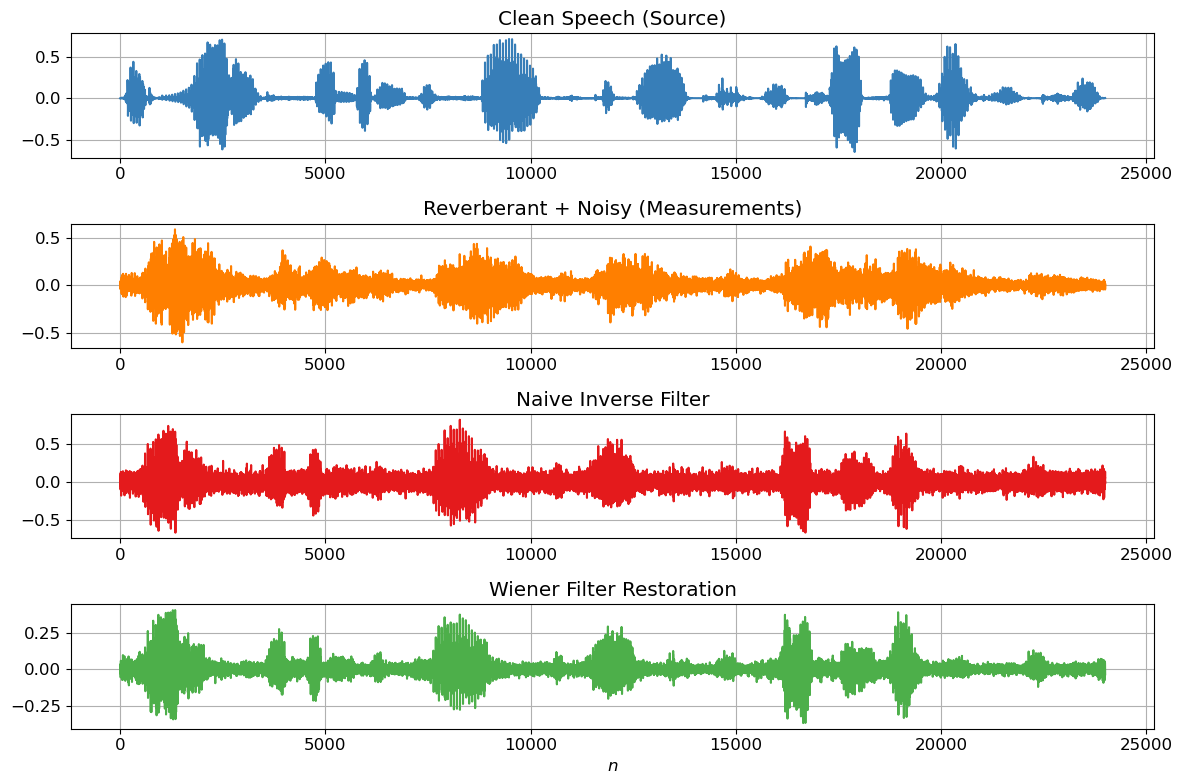

In [9]:
# 5. Visualization
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.title("Clean Speech (Source)")
plt.plot(clean_speech, color=colors['blue'])
plt.grid(True)

plt.subplot(4, 1, 2)
plt.title("Reverberant + Noisy (Measurements)")
plt.plot(observed_signal, color=colors['orange'])
plt.grid(True)

plt.subplot(4, 1, 3)
plt.title("Naive Inverse Filter")
plt.plot(recovered_naive, color=colors['red'])
plt.grid(True)

plt.subplot(4, 1, 4)
plt.title("Wiener Filter Restoration")
plt.plot(recovered_wiener, color=colors['green'])
plt.grid(True)
plt.xlabel("$n$")

plt.tight_layout()
plt.show()

In [10]:
import IPython.display as ipd

print("1. Clean Speech")
ipd.display(ipd.Audio(clean_speech, rate=sr))

print("2. Reverberant + Noisy")
ipd.display(ipd.Audio(observed_signal, rate=sr))

print("3. Naive Inverse Filter")
ipd.display(ipd.Audio(recovered_naive, rate=sr))

print("4. Wiener Restored")
ipd.display(ipd.Audio(recovered_wiener, rate=sr))

1. Clean Speech


2. Reverberant + Noisy


3. Naive Inverse Filter


4. Wiener Restored


## Part 4/5: 2D Image Deblurring (Set5 & Levin Kernels)

We apply the same Wiener Filter logic to images.
* **Gaussian Blur:** Simulates out-of-focus lens.
* **Motion Blur:** Simulates camera shake (Levin-like kernels).
* **Inverse Filter:** Fails due to zeros in the blur kernel.
* **Wiener Filter:** Restores structure by regularizing the inversion.

In [11]:
from PIL import Image
def get_image_sample():
    """Downloads 'baby.png' from Set5."""
    url = "https://raw.githubusercontent.com/jbhuang0604/SelfExSR/master/data/Set5/image_SRF_4/img_001_SRF_4_HR.png"
    try:
        print(f"Downloading Set5 image from {url}...")
        with urllib.request.urlopen(url) as response:
            data = response.read()
        img = Image.open(io.BytesIO(data)).convert('L') # Convert to Grayscale
        img = np.array(img).astype(float) / 255.0
        print("Download successful.")
        return img
    except Exception as e:
        print(f"Download failed ({e}). Generating synthetic text image...")

In [12]:
size = 3
start = size // 2
X, Y = np.meshgrid(np.arange(-start, -start + size), np.arange(-start, -start + size))
(X ** 2) + (Y ** 2)

array([[2, 1, 2],
       [1, 0, 1],
       [2, 1, 2]])

In [13]:
def get_gaussian_kernel(size=15, sigma=3):
    """Generates a 2D Gaussian Kernel."""
    # TODO: Implement Gaussian kernel generation
    start = size // 2
    X, Y = np.meshgrid(np.arange(-start, -start + size), np.arange(-start, -start + size))
    dist = (X ** 2) + (Y ** 2)
    kernel = np.exp(-dist / (2 * (sigma ** 2)))
    kernel = kernel / np.sum(kernel)
    return kernel


def get_motion_kernel(size=15, angle=45):
    """Generates a Motion Blur Kernel (Line)."""
    kernel = np.zeros((size, size))
    # Draw a line in the center using a simple algorithm
    center = size // 2
    slope = np.tan(np.deg2rad(angle))
    for x in range(size):
        offset = int((x - center) * slope)
        y = center - offset
        if 0 <= y < size:
            kernel[y, x] = 1.0
    return kernel / np.sum(kernel)

In [14]:
def wiener_deconvolution_2d(img_blurred, kernel, K):
    """
    Performs 2D Wiener Deconvolution in Frequency Domain.
    """
    # TODO: Implement Wiener Deconvolution
    # TODO: Pad kernel to image size
    # TODO: Wiener filter in the frequency domain
    X = np.fft.fft2(img_blurred)
    kernel = np.fft.ifftshift(kernel)
    H = np.fft.fft2(kernel, s = img_blurred.shape)
    H_conj = np.conjugate(H)
    G = H_conj / ((np.abs(H) ** 2) + K)

    X_hat = G * X
    return np.fft.ifft2(X_hat).real

In [15]:
# 1. Setup Data
img = get_image_sample()
k_motion = get_motion_kernel(size=15, angle=30)

# 2. Simulate Degradation
# We use fftconvolve for accurate boundary handling (or standard convolve2d)
img_blurred = scipy.signal.convolve2d(img, k_motion, mode='same', boundary='wrap')

# 3. Add Noise
noise_sigma = 0.01  # Gaussian noise
noise = np.random.randn(*img.shape) * noise_sigma
img_degraded = img_blurred + noise

# 4. Restoration
# K should be approx (Noise Power / Signal Power) or tuned manually
# Try K=0 for Inverse Filter (will explode)
img_inverse = wiener_deconvolution_2d(img_degraded, k_motion, K=1e-12) 
# Try Tuned K for Wiener
K = 9e-2
img_wiener = wiener_deconvolution_2d(img_degraded, k_motion, K=K)

Download successful.


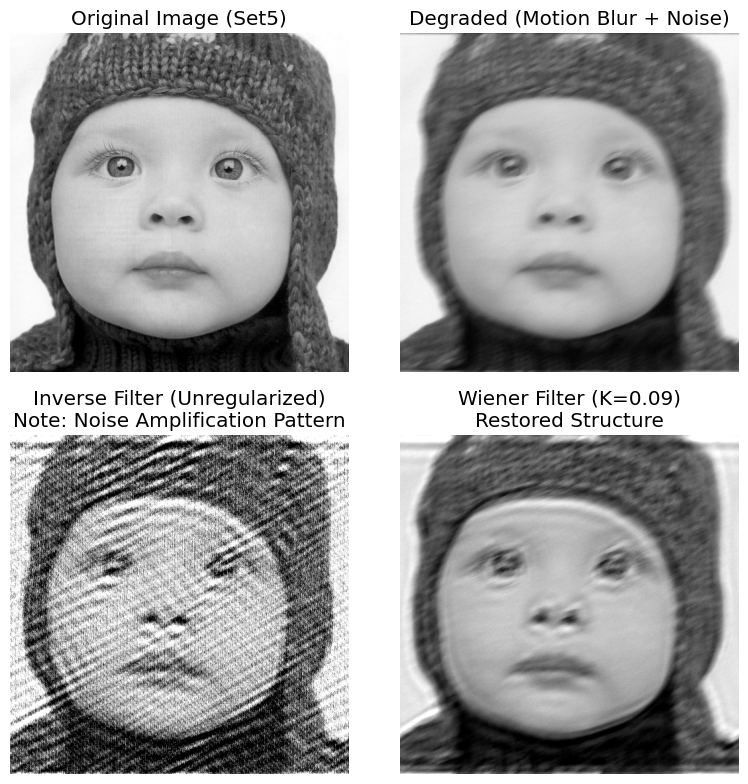

In [16]:
# 5. Visualization
plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.title("Original Image (Set5)")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title(f"Degraded (Motion Blur + Noise)")
plt.imshow(img_degraded, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Inverse Filter (Unregularized)\nNote: Noise Amplification Pattern")
plt.imshow(np.clip(img_inverse, 0, 1), cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title(f"Wiener Filter (K={K})\nRestored Structure")
plt.imshow(np.clip(img_wiener, 0, 1), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Part 6: Blind Deconvolution

- **Observation:** Motion blur, "unknown"
- **Restoration:** Parametrize the kernel as Gaussian and find parameters

In [17]:
def get_mystery_image():
    """Loads the 'Page' image."""
    try:
        print(f"Loading mystery image from local file...")
        img = Image.open("data/page.png").convert('L')
        img = np.array(img).astype(float) / 255.0
        return img
    except Exception as e:
        print(f"Failed to load.")

In [18]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0: return 100
    return 10 * np.log10(1.0 / mse)

# 1. Prepare the 
gt_img = get_mystery_image()
mystery_sigma = 2.4
mystery_kernel = get_gaussian_kernel(size=21, sigma=mystery_sigma)
# mystery_kernel = get_motion_kernel(size=7, angle=30)
mystery_blur = scipy.signal.convolve2d(gt_img, mystery_kernel, mode='same', boundary='wrap')
mystery_noise = np.random.randn(*gt_img.shape) * 0.02
mystery_observed = mystery_blur + mystery_noise

Loading mystery image from local file...


In [19]:
# TODO: Restore using an estimate of the kernel as Gaussian filter
# TODO: Find the optimal parameters
# TODO: Display results and PSNR
sigmas = np.arange(0.5, 5, 0.5, dtype=np.float64)
K_list = [0.005, 0.01, 0.02, 0.05, 0.1, 0.5]
window_list = np.arange(3, 26, 2, dtype=np.int64)
best_psnr = 0
best_param = {"size": 0, "sigma": 0, "K": 0}
best_recovered_img = 0
recovered_img = {}
psnr_list = {}

for size in window_list:
    psnr_list[size] = {}
    recovered_img[size] = {}
    for sigma in sigmas:
        psnr_list[size][sigma] = []
        recovered_img[size][sigma] = {}
        for K in K_list:
            kernel = get_gaussian_kernel(size, sigma)
            rec_img = wiener_deconvolution_2d(mystery_observed, kernel, K)
            recovered_img[size][sigma][K] = rec_img
            
            psnr = calculate_psnr(rec_img, gt_img)
            psnr_list[size][sigma].append(psnr)
            print(f"""Size: {size} | Sigma: {sigma} | K: {K:.3f} | PSNR: {psnr:.4f}""")
            if psnr > best_psnr:
                best_psnr = psnr
                best_param['size'] = size
                best_param['sigma'] = sigma
                best_param['K'] = K
                best_recovered_img = rec_img
        

Size: 3 | Sigma: 0.5 | K: 0.005 | PSNR: 18.2719
Size: 3 | Sigma: 0.5 | K: 0.010 | PSNR: 18.2648
Size: 3 | Sigma: 0.5 | K: 0.020 | PSNR: 18.2300
Size: 3 | Sigma: 0.5 | K: 0.050 | PSNR: 17.9826
Size: 3 | Sigma: 0.5 | K: 0.100 | PSNR: 17.2535
Size: 3 | Sigma: 0.5 | K: 0.500 | PSNR: 11.5990
Size: 3 | Sigma: 1.0 | K: 0.005 | PSNR: 16.3671
Size: 3 | Sigma: 1.0 | K: 0.010 | PSNR: 17.0312
Size: 3 | Sigma: 1.0 | K: 0.020 | PSNR: 17.5320
Size: 3 | Sigma: 1.0 | K: 0.050 | PSNR: 17.7322
Size: 3 | Sigma: 1.0 | K: 0.100 | PSNR: 17.1604
Size: 3 | Sigma: 1.0 | K: 0.500 | PSNR: 11.5841
Size: 3 | Sigma: 1.5 | K: 0.005 | PSNR: 16.2371
Size: 3 | Sigma: 1.5 | K: 0.010 | PSNR: 17.0433
Size: 3 | Sigma: 1.5 | K: 0.020 | PSNR: 17.5723
Size: 3 | Sigma: 1.5 | K: 0.050 | PSNR: 17.7379
Size: 3 | Sigma: 1.5 | K: 0.100 | PSNR: 17.1443
Size: 3 | Sigma: 1.5 | K: 0.500 | PSNR: 11.5774
Size: 3 | Sigma: 2.0 | K: 0.005 | PSNR: 16.2930
Size: 3 | Sigma: 2.0 | K: 0.010 | PSNR: 17.0886
Size: 3 | Sigma: 2.0 | K: 0.020 | PSNR: 

In [20]:
print(f"""Optimal Parameters : Size = {best_param['size']} | Sigma = {best_param['sigma']} | K = {best_param['K']} | with PSNR: {best_psnr:.4f}""")

Optimal Parameters : Size = 9 | Sigma = 0.5 | K = 0.005 | with PSNR: 18.3836


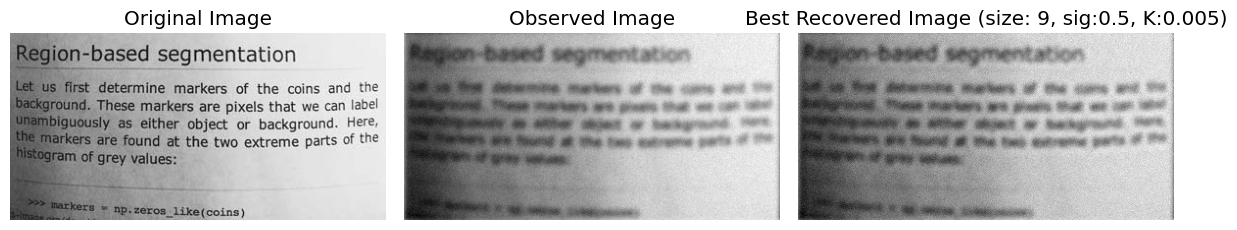

In [21]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
axes[0].imshow(gt_img, cmap = 'gray')
axes[0].set_title(f"""Original Image""")
axes[0].axis('off')
axes[1].imshow(mystery_observed, cmap = 'gray')
axes[1].set_title(f"""Observed Image""")
axes[1].axis('off')
axes[2].imshow(best_recovered_img, cmap = 'gray')
axes[2].set_title(f"""Best Recovered Image (size: {best_param['size']}, sig:{best_param['sigma']}, K:{best_param['K']})""")
axes[2].axis('off')
plt.tight_layout()
plt.show()


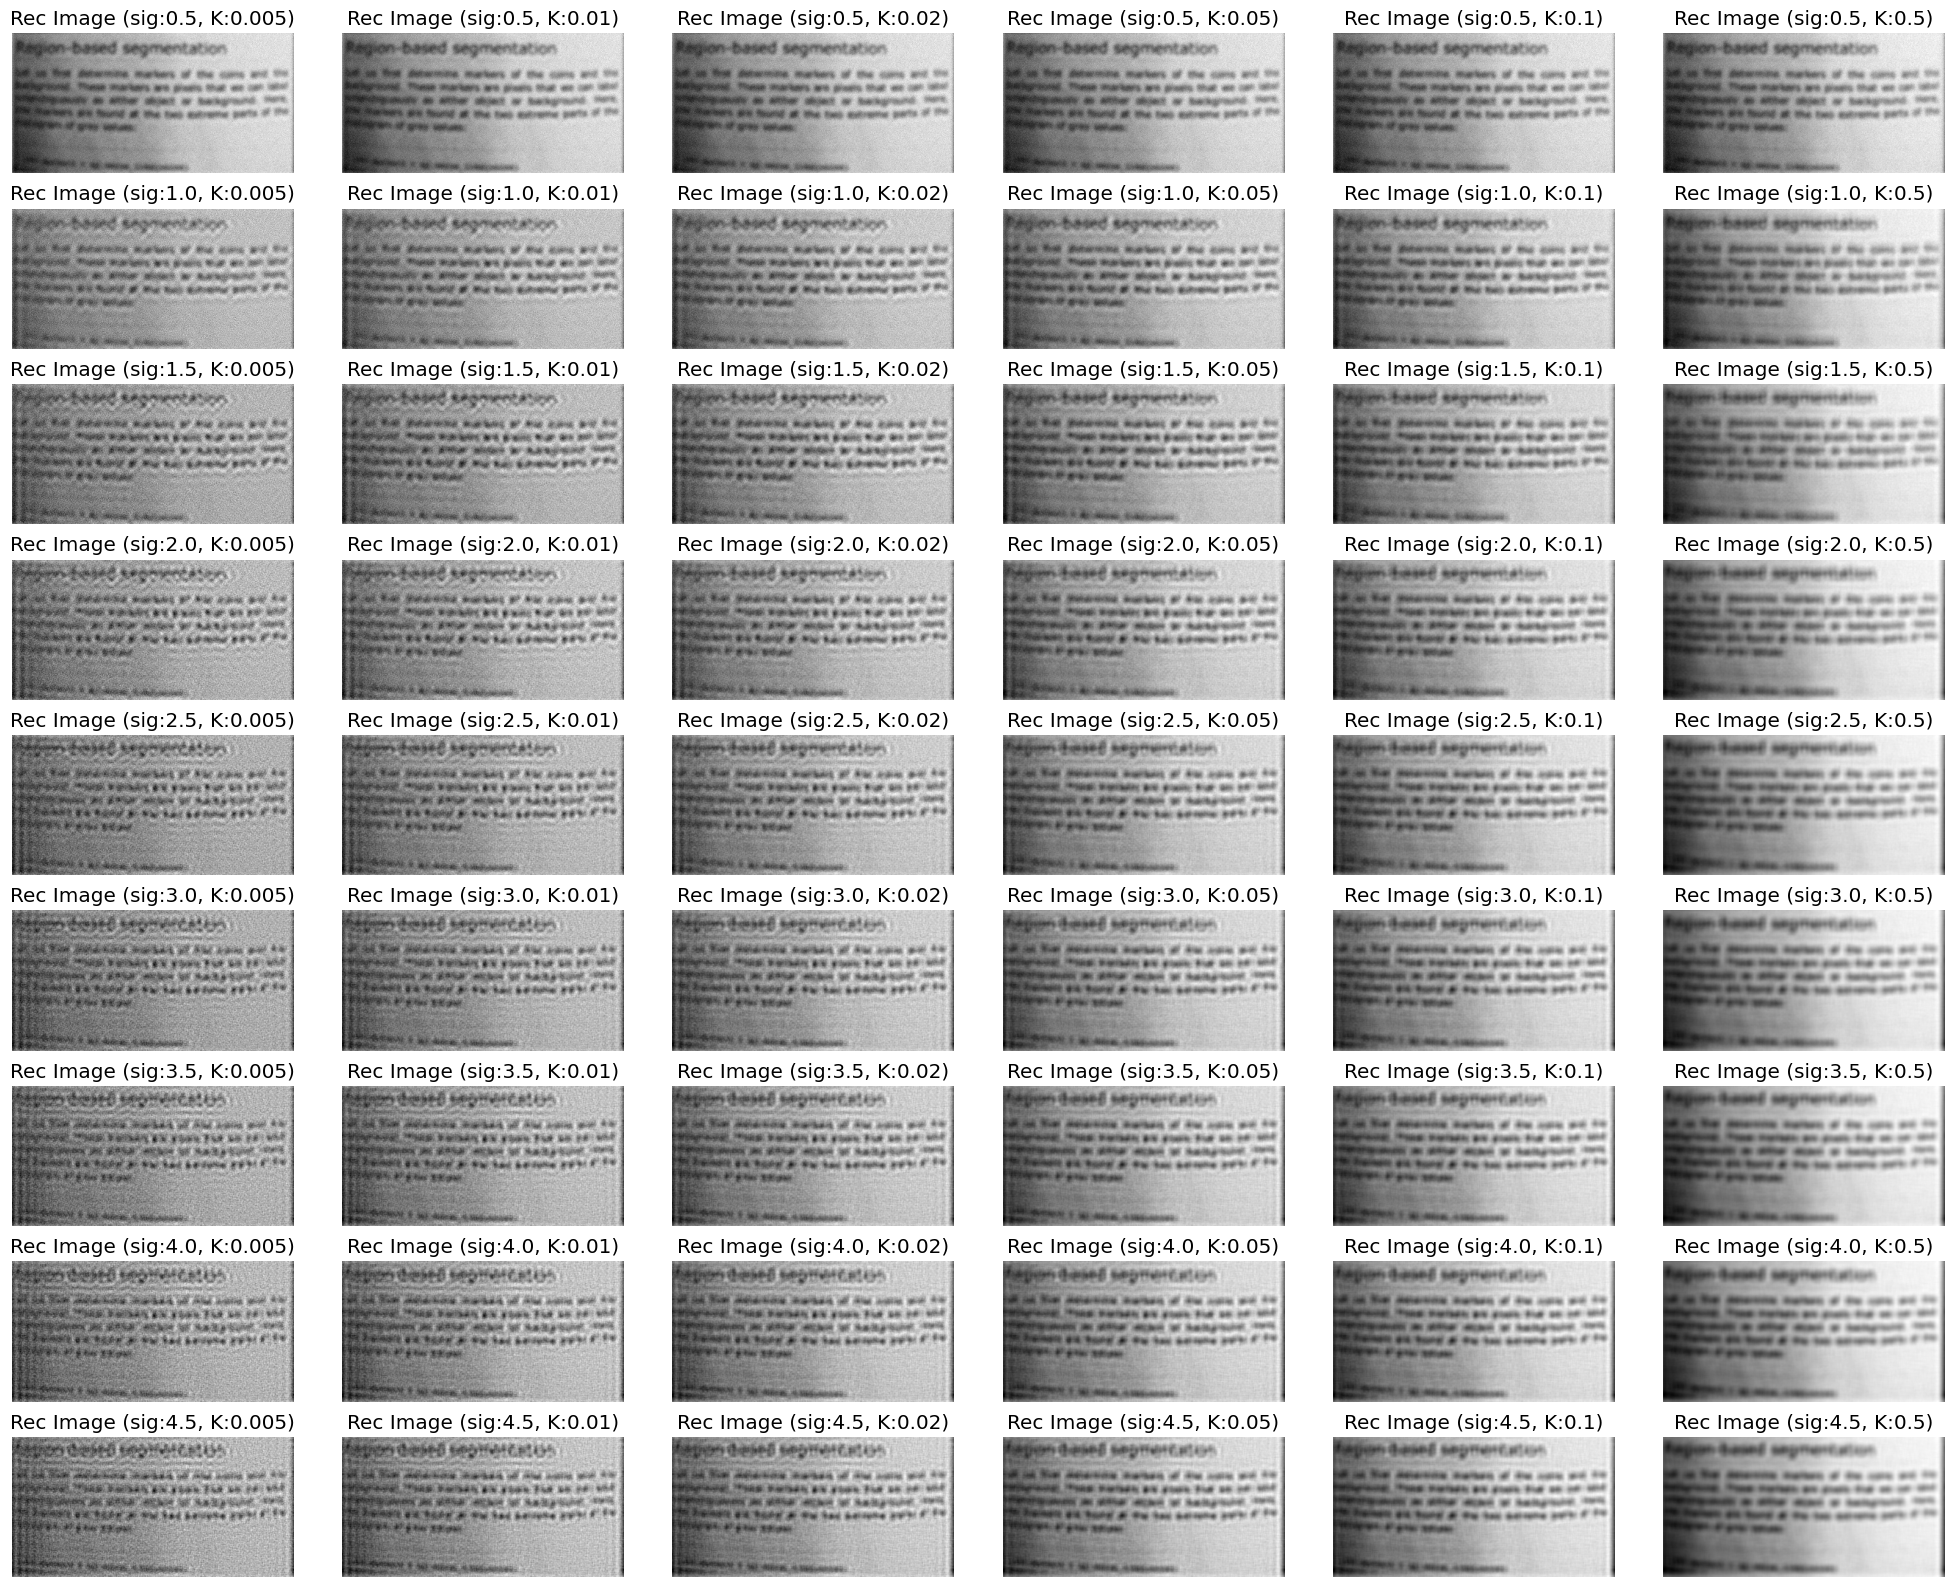

In [22]:
fig,axes = plt.subplots(nrows=len(sigmas), ncols=len(K_list), figsize=(20, 16))
for i, sigma in enumerate(sigmas):
    for j, K in enumerate(K_list):
        axes[i, j].imshow(recovered_img[best_param['size']][sigma][K], cmap = "gray")
        axes[i, j].set_title(f"""Rec Image (sig:{sigma}, K:{K})""")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


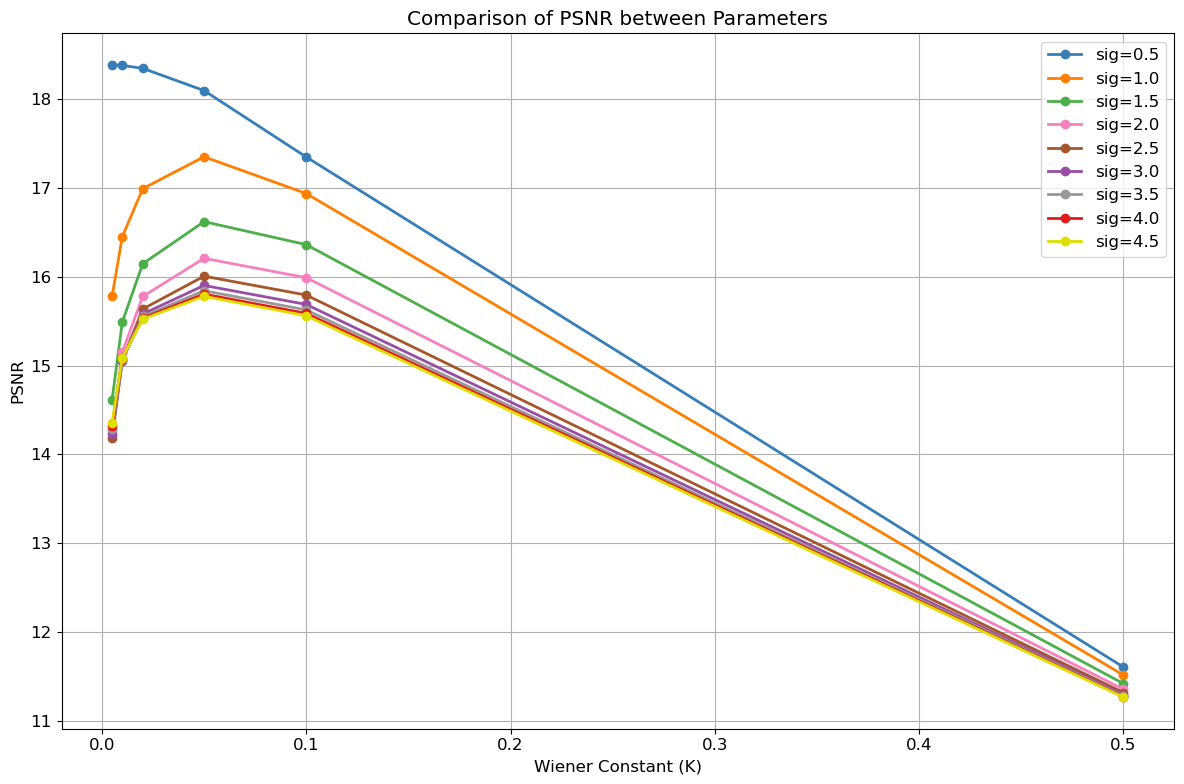

In [23]:
colours = list(colors.keys())
plt.figure(figsize=(12, 8))
for i, sigma in enumerate(sigmas):
    plt.plot(K_list, psnr_list[best_param['size']][sigma], marker = 'o', linestyle = '-', linewidth = 2, color = colors[colours[i]], label=f"""sig={sigma}""")

plt.title("Comparison of PSNR between Parameters")
plt.xlabel("Wiener Constant (K)")
plt.ylabel("PSNR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()